In [1]:
import gzip
from collections import defaultdict

## data loading

In [70]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

allHelpful = []
userHelpful = defaultdict(list)
itemReview = defaultdict(list) # new
ratingHelpful = defaultdict(list)

for l in readGz("train.json.gz"):
  user,item = l['reviewerID'],l['itemID']
  allHelpful.append(l['helpful'])
  userHelpful[user].append(l['helpful'])
  itemReview[item].append(l)
  ratingHelpful[l['rating']].append(l['helpful'])

averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
userRate = {}
for u in userHelpful:
  userReviewCount = len(userHelpful[u])
  userTotalOutOf = sum([x['outOf'] for x in userHelpful[u]])
  userTotalHelpful = sum([x['nHelpful'] for x in userHelpful[u]])
  if userTotalOutOf > 0 and userReviewCount > 5:
    userRate[u] = userTotalHelpful * 1.0 / userTotalOutOf
  else:
    userRate[u] = averageRate

itemRate = {}
for i in itemReview:
  itemReviewCount = len(itemReview[i])
  itemTotalOutOf = sum([x['helpful']['outOf'] for x in itemReview[i]])
  itemTotalHelpful = sum([x['helpful']['nHelpful'] for x in itemReview[i]])
  if itemTotalOutOf > 0 and itemReviewCount > 20:
    itemRate[i] = itemTotalHelpful * 1.0 / itemTotalOutOf
  else:
    itemRate[i] = averageRate
  
    
ratingRate = {}
for r in ratingHelpful:
  totalOutOf = sum([x['outOf'] for x in ratingHelpful[r]])
  totalHelpful = sum([x['nHelpful'] for x in ratingHelpful[r]])
  ratingRate[r] = totalHelpful * 1.0 / totalOutOf

### load as dataframe

In [71]:
import pandas as pd
from collections import defaultdict

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

### data preprocessing ###

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

print(df.shape, test_df.shape)

(200000, 12) (14000, 12)


In [73]:
df['outOf'] = df.apply(lambda row: row['helpful']['outOf'], axis=1)
df['nHelpful'] = df.apply(lambda row: row['helpful']['nHelpful'], axis=1)

df['userRate'] = df.apply(lambda row: userRate.get(row['reviewerID'], averageRate), axis=1)
df['itemRate'] = df.apply(lambda row: itemRate.get(row['itemID'], averageRate) , axis=1)

df['itemReviewCount'] = df['itemID'].groupby(df['itemID']).transform('count')
df['userReviewCount'] = df['reviewerID'].groupby(df['reviewerID']).transform('count')

df['userAvgOutOf'] = df['outOf'].groupby(df['reviewerID']).transform('mean')
df['itemAvgOutOf'] = df['outOf'].groupby(df['itemID']).transform('mean')

df['itemOutOfRatio'] = df.apply(lambda row: row['outOf']/row['itemAvgOutOf'] if row['itemAvgOutOf'] != 0 else 0 , axis=1)
df['itemOutOfRatio1'] = df.apply(lambda row: row['outOf']/row['itemAvgOutOf1'] if row['itemAvgOutOf1'] != 0 else 0 , axis=1)

df['itemAvgRating'] = df['rating'].groupby(df['itemID']).transform('mean')
df['itemRatingDev'] = df['rating'] - df['itemAvgRating']

df['reviewLength'] = df['reviewText'].str.len()
df['itemAvgReviewLength'] = df['reviewLength'].groupby(df['itemID']).transform('mean')
df['itemReviewLengthRatio'] = df['reviewLength'] / df['itemAvgReviewLength']

df['itemReviewTimeFirst'] = df['unixReviewTime'].groupby(df['itemID']).transform('min')
df['itemReviewTimeLast'] = df['unixReviewTime'].groupby(df['itemID']).transform('max')
df['itemReviewTimeSpan'] = df['itemReviewTimeLast']-df['itemReviewTimeFirst']
df['itemReviewTimePast'] = df['unixReviewTime']-df['itemReviewTimeFirst']
df['itemReviewTimeRatio'] = df['itemReviewTimePast'] / df['itemReviewTimeSpan']


df['helpfulRate'] = df.apply(lambda row: row['nHelpful']/row['outOf'] if row['outOf']!=0 else 0 , axis=1)

KeyError: ('itemAvgOutOf1', 'occurred at index 0')

In [6]:
test_df['reviewLength'] = test_df.apply(lambda row: len(row['reviewText']), axis=1)
test_df['outOf'] = test_df.apply(lambda row: row['helpful']['outOf'], axis=1)

test_df['userRate'] = test_df.apply(lambda row: userRate.get(row['reviewerID'], averageRate), axis=1)
test_df['itemRate'] = test_df.apply(lambda row: itemRate.get(row['itemID'], averageRate), axis=1)

test_df['itemReviewCount'] = test_df.apply(lambda row: itemReviewCount[row['itemID']], axis=1)
test_df['itemReviewCount1'] = test_df.apply(lambda row: itemReviewCount1[row['itemID']], axis=1)
test_df['userReviewCount'] = test_df.apply(lambda row: userReviewCount.get(row['reviewerID'],0), axis=1)
test_df['userReviewCount1'] = test_df.apply(lambda row: userReviewCount1.get(row['reviewerID'],0), axis=1)

# AvgHelpful = TotalHepful / ReviewCount
#has nan
#test_df['userAvgOutOf'] = test_df.apply(lambda row: userAvgOutOf.get(row['reviewerID'], 0) , axis=1)
#test_df['userAvgHelpful'] = test_df.apply(lambda row: userAvgHelpful.get(row['reviewerID']) , axis=1)  # userAvgHelpful = userRate * userAvgOutOf
test_df['itemAvgOutOf'] = test_df.apply(lambda row: itemAvgOutOf.get(row['itemID']) , axis=1)

# redundant
#test_df['userAvgHelpful1'] = test_df.apply(lambda row: userAvgHelpful1.get(row['reviewerID']) , axis=1)  #= userRate * userAvgOutOf1
#nan
#test_df['userAvgOutOf1'] = test_df.apply(lambda row: userAvgOutOf1.get(row['reviewerID'], 0) , axis=1)
test_df['itemAvgOutOf1'] = test_df.apply(lambda row: itemAvgOutOf1.get(row['itemID']) , axis=1)

test_df['itemOutOfRatio'] = test_df.apply(lambda row: row['outOf']/row['itemAvgOutOf'] if row['itemAvgOutOf'] != 0 else 0 , axis=1)
test_df['itemOutOfRatio1'] = test_df.apply(lambda row: row['outOf']/row['itemAvgOutOf1'] if row['itemAvgOutOf1'] != 0 else 0 , axis=1)

test_df['itemAvgRating'] = test_df['rating'].groupby(test_df['itemID']).transform('mean')
test_df['itemRatingDev'] = test_df['rating'] - test_df['itemAvgRating']

test_df['reviewLength'] = test_df['reviewText'].str.len()
test_df['itemAvgReviewLength'] = test_df['reviewLength'].groupby(test_df['itemID']).transform('mean')
test_df['itemReviewLengthRatio'] = test_df['reviewLength'] / test_df['itemAvgReviewLength']

test_df['itemReviewTimeFirst'] = test_df['unixReviewTime'].groupby(test_df['itemID']).transform('min')
test_df['itemReviewTimeLast'] = test_df['unixReviewTime'].groupby(test_df['itemID']).transform('max')
test_df['itemReviewTimeSpan'] = test_df['itemReviewTimeLast']-test_df['itemReviewTimeFirst']
test_df['itemReviewTimePast'] = test_df['unixReviewTime']-test_df['itemReviewTimeFirst']
test_df['itemReviewTimeRatio'] = test_df['itemReviewTimePast'] / test_df['itemReviewTimeSpan']

# not quite useful
test_df['itemReviewTimeSpan'] = test_df.apply(lambda row: itemReviewTimeLast[row['itemID']] - itemReviewTimeFirst[row['itemID']], axis=1)
test_df['itemReviewTimeRatio'] = test_df.apply(lambda row: (row['unixReviewTime']-itemReviewTimeFirst[row['itemID']])/itemReviewTimeSpan[row['itemID']] if itemReviewTimeSpan[row['itemID']] > 0 else 0 , axis=1)

test_df['summaryLength'] = test_df.apply(lambda row: len(row['summary']), axis=1)

## investigate data ##

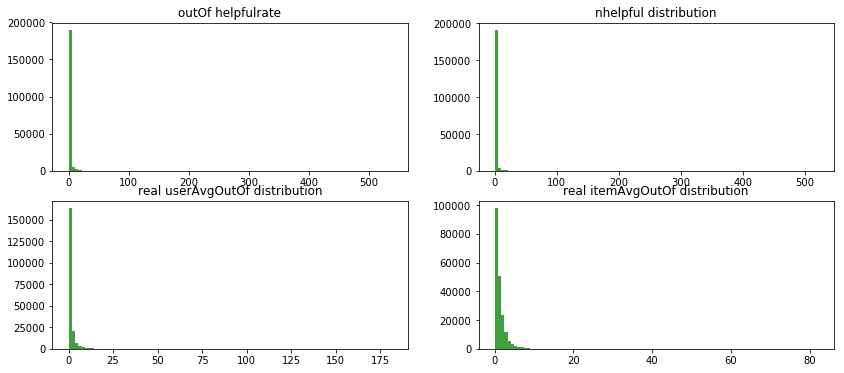

In [10]:
# check distribution of several features
plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.title('outOf helpfulrate')
plt.hist(df['outOf'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.subplot(2,2,2)
plt.title('nhelpful distribution')
plt.hist(df['nHelpful'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.subplot(2,2,3)
plt.title('real userAvgOutOf distribution')
plt.hist(df['userAvgOutOf'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.subplot(2,2,4)
plt.title('real itemAvgOutOf distribution')
plt.hist(df['itemAvgOutOf'], 100, histtype='bar', facecolor='green', alpha=0.75)

plt.show()

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


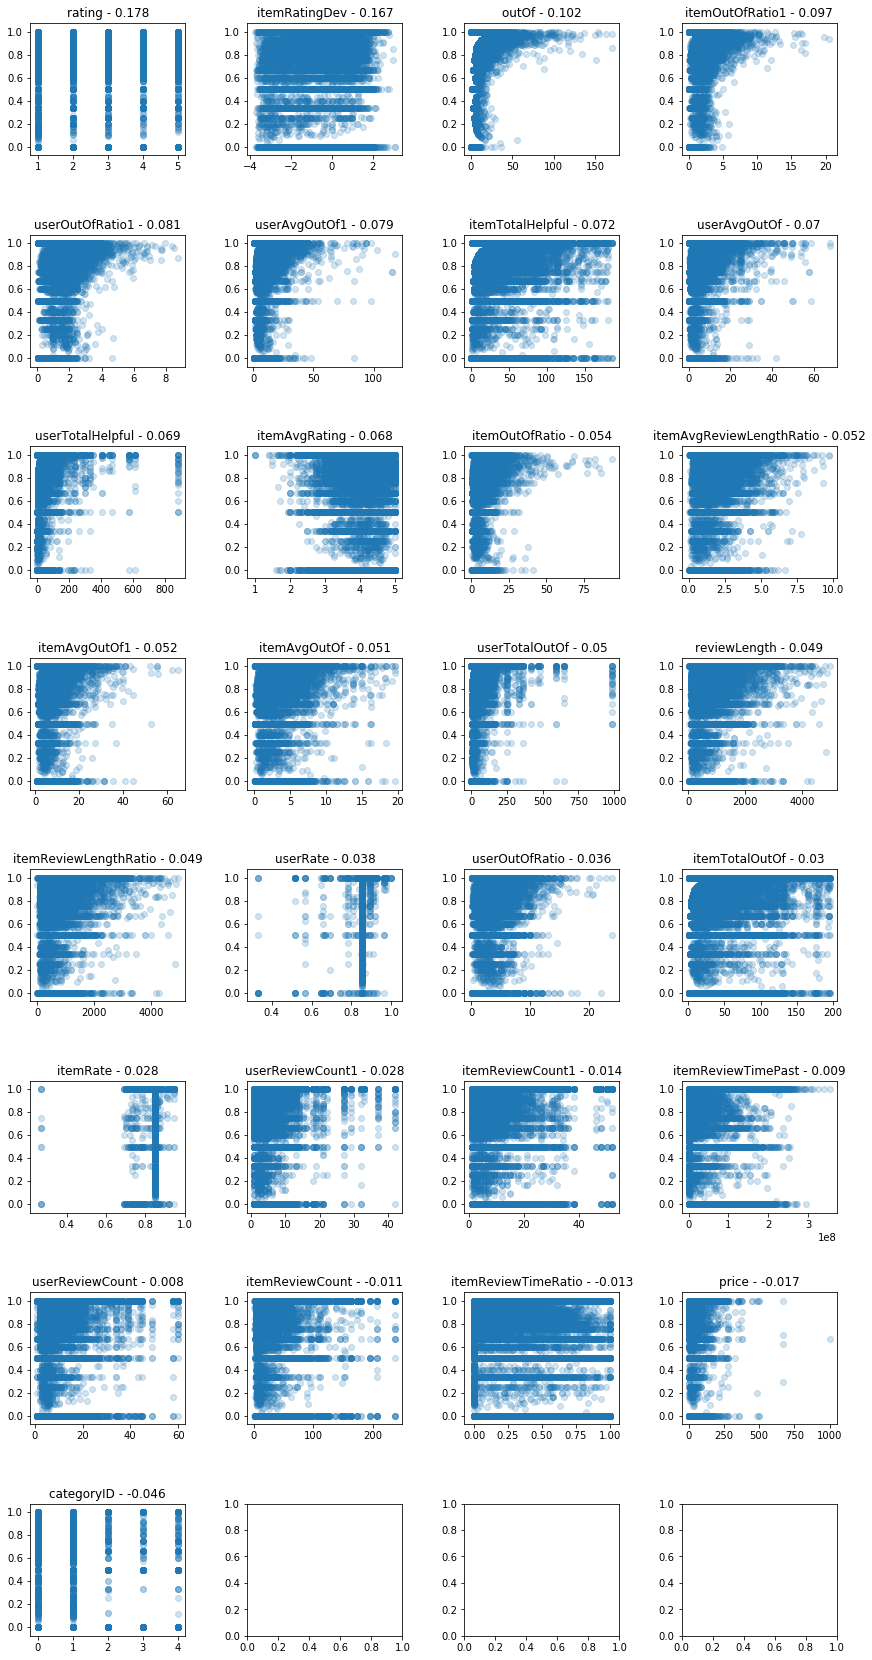

['rating', 'itemRatingDev', 'outOf', 'itemOutOfRatio1', 'userOutOfRatio1', 'userAvgOutOf1', 'itemTotalHelpful', 'userAvgOutOf', 'userTotalHelpful', 'itemAvgRating', 'itemOutOfRatio', 'itemAvgReviewLengthRatio', 'itemAvgOutOf1', 'itemAvgOutOf', 'userTotalOutOf', 'reviewLength', 'itemReviewLengthRatio', 'userRate', 'userOutOfRatio', 'itemTotalOutOf', 'itemRate', 'userReviewCount1', 'itemReviewCount1', 'itemReviewTimePast', 'userReviewCount', 'itemReviewCount', 'itemReviewTimeRatio', 'price', 'categoryID']


In [40]:
# scatter plot of features vs helpfulness
df_valid = df[(df['outOf'] > 0 ) & (df['outOf'] < 500) \
              & (df['reviewLength'] < 5000) \
              & (df['itemAvgOutOf'] < 20) \
              & (df['userAvgOutOf'] < 70) \
              & (df['userReviewCount'] < 75) \
              & (df['itemAvgReviewLengthRatio'] < 10) \
              & (df['itemReviewLengthRatio'] < 10000) \
              & (df['itemTotalOutOf'] < 200) ]

all_features = ['userRate', 'itemRate', 'outOf',  \
                'reviewLength', 'itemReviewLengthRatio', 'itemAvgReviewLengthRatio', \
                'itemAvgOutOf', 'userAvgOutOf', \
                'itemReviewCount', 'itemReviewCount1', 'userReviewCount', 'userReviewCount1', \
                'itemOutOfRatio', 'itemOutOfRatio1', \
                'itemAvgRating', 'itemRatingDev', 'itemReviewTimePast',\
                'itemReviewTimeRatio', 'categoryID', 'price',  'rating' \
                ]
corrs = {}
for feature in all_features:
    df1 = df_valid[np.isfinite(df_valid[feature])]
    corrs[feature] = df1[feature].corr(df1['helpfulRate'])

fig, ax = plt.subplots(8, 4)
fig.subplots_adjust(left=0.1, right=0.9,
                    bottom=0.1, top=0.9,
                    hspace=0.6, wspace=0.4)
fig.set_size_inches(14,28)
sorted_features = sorted(all_features, key=lambda x: corrs[x], reverse=True)
for i,feature in enumerate(sorted_features):
    df1 = df_valid[np.isfinite(df_valid[feature])]
    corr = corrs[feature]
    x,y = i/4, i%4
    ax[x,y].set_title('{} - {}'.format(feature,round(corr,3)))
    ax[x,y].scatter(df1[feature], df1['helpfulRate'], alpha=0.2)
plt.show()
print(sorted_features)

## feature extraction ##
This is a regression problem, and the target variable is review helpful rate.

Intuitively, these features should be useful, need plot and check the correlation.
* rating: 
* **outOf count**
* price
* unixReviewTime
* **history rate**: if user exists use userRate else use averageRate
* history rate per category
* reviewText Length

In [15]:
# try different features
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

features = ['rating', 'itemRatingDev', 'outOf',  'itemOutOfRatio1', \
            'userAvgOutOf',\
            'userTotalHelpful', 'itemAvgRating', 'itemAvgReviewLengthRatio', 'itemAvgOutOf'\
            #'itemOutOfRatio', 'reviewLength', 'itemReviewLengthRatio',\
            #'userReviewCount', 'userReviewCount1', 'summaryLength', \
            #'itemReviewTimeRatio', 'itemReviewTimePast', 'itemReviewCount',\
            #'itemReviewCount1', 'categoryID', 'price'\
           ]
priority = {}
for i in range(len(features)):
  selected = features[:i] + features[i+1:]
  #selected = [features[i]]
  X_train, X_val, y_train, y_val = train_test_split(df_valid[features], df_valid[['helpfulRate','nHelpful']], test_size=0.2, random_state=5)
  best_mae = 100
  best_param = []
  for d in [1]:
      for m in ['linear', 'ridge']:
        if m == 'linear':
            model = Pipeline([('poly', PolynomialFeatures(degree=d)),
                               (m, LinearRegression(fit_intercept=True, normalize=True))]).fit(X_train[selected], y_train['helpfulRate'])
        elif m == 'ridge':
            model = Pipeline([('poly', PolynomialFeatures(degree=d)),
                               (m, Ridge(fit_intercept=True, random_state=0, max_iter=1000, normalize=True))]).fit(X_train[selected], y_train['helpfulRate'])
        else:
            model = Pipeline([('poly', PolynomialFeatures(degree=d)),
                               (m, Lasso(fit_intercept=True, random_state=0, max_iter=2000, normalize=True))]).fit(X_train[selected], y_train['helpfulRate'])
        y_pred = np.clip(model.predict(X_val[selected]), 0, 1)
        X_val['helpfulRate'] = y_pred
        X_val['nHelpful'] = X_val.apply(lambda row: round(row['helpfulRate'] * row['outOf']), axis=1)
        #mae = mean_absolute_error(y_val['nHelpful'], X_val['nHelpful'])
        mae = mean_squared_error(y_pred, y_val['helpfulRate'])
        #print(m, d, mae)
        if mae < best_mae:
            best_mae = mae
            best_param = [m, d]

  print("removing features: {} best mae:{} and param:{}".format(features[i], best_mae, best_param))
  priority[features[i]] = best_mae
    

removing features: rating best mae:0.11454827672506612 and param:['linear', 1]
removing features: itemRatingDev best mae:0.11454827672506611 and param:['linear', 1]
removing features: outOf best mae:0.11454980539512018 and param:['linear', 1]
removing features: itemOutOfRatio1 best mae:0.11462586425894034 and param:['linear', 1]
removing features: userOutOfRatio1 best mae:0.11470815423291214 and param:['linear', 1]
removing features: userAvgOutOf1 best mae:0.11462814410010602 and param:['linear', 1]
removing features: itemTotalHelpful best mae:0.1149689647879707 and param:['linear', 1]
removing features: userAvgOutOf best mae:0.11455884487145984 and param:['linear', 1]
removing features: userTotalHelpful best mae:0.11463567826869388 and param:['linear', 1]
removing features: itemAvgRating best mae:0.11454827672506612 and param:['linear', 1]
removing features: itemAvgReviewLengthRatio best mae:0.11456831178767647 and param:['linear', 1]
removing features: itemAvgOutOf1 best mae:0.114555

In [16]:
import operator
sorted(priority.items(), key=operator.itemgetter(1))

[('itemRatingDev', 0.11454827672506611),
 ('rating', 0.11454827672506612),
 ('itemAvgRating', 0.11454827672506612),
 ('outOf', 0.11454980539512018),
 ('itemAvgOutOf1', 0.11455562263403324),
 ('userAvgOutOf', 0.11455884487145984),
 ('itemAvgReviewLengthRatio', 0.11456831178767647),
 ('itemOutOfRatio1', 0.11462586425894034),
 ('userAvgOutOf1', 0.11462814410010602),
 ('userTotalHelpful', 0.11463567826869388),
 ('userOutOfRatio1', 0.11470815423291214),
 ('itemTotalHelpful', 0.1149689647879707)]

## model selection ##

### basic model ###

In [23]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

In [19]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=5)

In [26]:
# try different regression models
df_valid = df_train[(df_train['outOf'] > 2) \
              & (df['outOf'] < 200) \
              #& (df['helpfulRate'] > 0.001) \
              & (df['reviewLength'] >30 ) \
             ]


features = ['rating', 'reviewLength', 'itemRatingDev', 'outOf', \
            'itemOutOfRatio1','itemRatingDev']

X_train, X_val, y_train, y_val = train_test_split(df_valid, df_valid[['helpfulRate','nHelpful']], test_size=0.2, random_state=4)
print("training size:{}, valid size:{}".format(X_train.shape[0], X_val.shape[0]))

best_mae = 100
best_param = []
best_model = 0
for k in ['rbf']:#, 'poly']:
  #for d in [1]: #',2]:
  for c in [0.05, 0.1]:
  #for c in [0.1, 0.2, 0.5, 1.0]:
    #for e in [0.03, 0.05, 0.07]:
    for e in[0.1]:
      model = svm.SVR(kernel=k, C=c, degree=1, epsilon=e).fit(X_train[features], y_train['helpfulRate'])
      helpfulRate = np.clip(model.predict(X_val[features]), 0, 1)
      nHelpful = round(helpfulRate * X_val['outOf'])
      mae = mean_absolute_error(y_val['nHelpful'], nHelpful)
      print('SVR:', (k, c, e), mae)
      if mae < best_mae:
        best_mae = mae
        best_param = [k, c, e]
        best_model = model

model = LinearRegression(fit_intercept=True, normalize=True).fit(X_train[features], y_train['helpfulRate'])
helpfulRate = np.clip(model.predict(X_val[features]), 0, 1)
nHelpful = round(helpfulRate * X_val['outOf'])
mae = mean_absolute_error(y_val['nHelpful'], nHelpful)
print('linear regression:', mae)
if mae < best_mae:
    best_mae = mae
    best_param = [k, c, e]
    best_model = model

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


training size:14272, valid size:3569
SVR: ('rbf', 0.05, 0.1) 1.03334267302
SVR: ('rbf', 0.1, 0.1) 1.07621182404
linear regression: 0.983468758756


In [28]:
helpfulRate= np.clip(best_model.predict(df_test[features]), 0, 1)
nHelpful= round(helpfulRate * df_test['outOf'])
mae = mean_absolute_error(df_test['nHelpful'], nHelpful)
print('best model:', best_model)
print('test mae:',mae)

best model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)
test mae: 0.186525


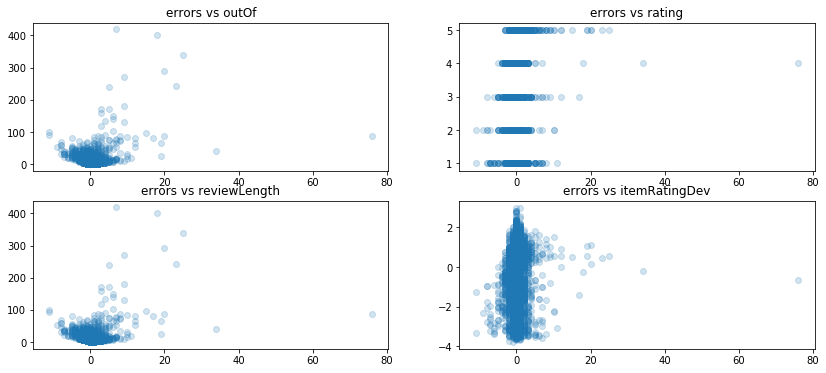

In [32]:
errors = nHelpful - df_test['nHelpful']
# check regression errors(residuals), it should be random(no pattern) if the model works well
plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.title('errors vs outOf')
plt.scatter(errors, df_test['outOf'], alpha=0.2)

plt.subplot(2,2,2)
plt.title('errors vs rating')
plt.scatter(errors, df_test['rating'], alpha=0.2)

plt.subplot(2,2,3)
plt.title('errors vs reviewLength')
plt.scatter(errors, df_test['outOf'], alpha=0.2)

plt.subplot(2,2,4)
plt.title('errors vs itemRatingDev')
plt.scatter(errors, df_test['itemRatingDev'], alpha=0.2)

plt.show()

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


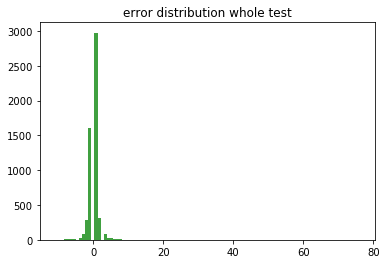

(36596, 43)


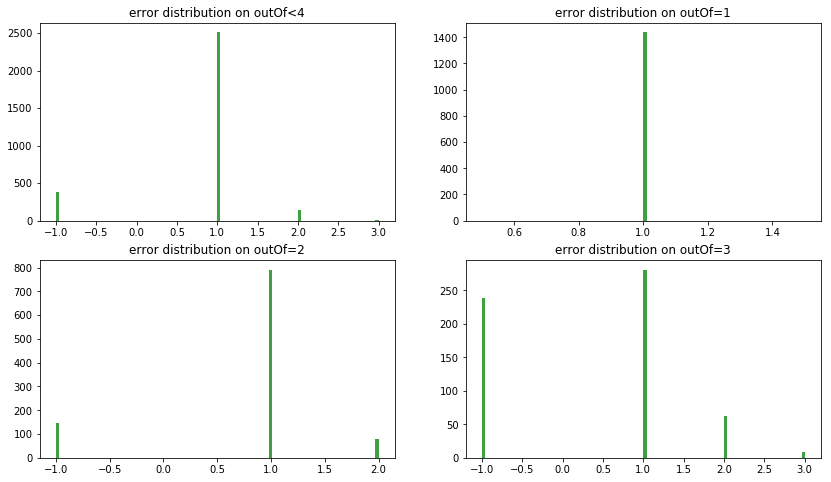

In [37]:
# check the errors on outOf<3, since that's majority from data distribution
df_test['error'] = errors

plt.title('error distribution whole test')
plt.hist(df_test[(df_test['error']!=0)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.show()

df1 = df_test[df_test['outOf']<4]
print(df_test[df_test['outOf']<4].shape)
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.title('error distribution on outOf<4')
plt.hist(df1[(df1['error']!=0)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(2,2,2)
plt.title('error distribution on outOf=1')
plt.hist(df1[(df1['error']!=0)&(df1['outOf']==1)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(2,2,3)
plt.title('error distribution on outOf=2')
plt.hist(df1[(df1['error']!=0)&(df1['outOf']==2)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.subplot(2,2,4)
plt.title('error distribution on outOf=3')
plt.hist(df1[(df1['error']!=0)&(df1['outOf']==3)]['error'], 100, histtype='bar', facecolor='green', alpha=0.75)
plt.show()


### problem ###
From above, one single model doesn't work well on test with small outOf, as errors are all 1 for outOf=1 while ideally they should be evenly distributed on [-1, 1].


### multiple clusters ###
Since the distribution of data according to outOf is long-tailed shape, try spliting the whole data to multiple segments, train different model for each of them. For testing, same segments will be applied.
* outOf == 0: nHelpful =0
* outOf == 1: classification with decision tree, SVM
* outOf > 1: split to 2 or more groups with linear regression model for each

### outOf==1, classification
Tried different models: decision tree, SVM
But they didn't work well, probably they

In [8]:
# for outOf=1, classification problem, nHelpful=[0,1]
df_valid = df[(df['outOf'] > 0) & (df['outOf'] < 2) \
              #& (df['nHelpful'] > 0) \
              & (df['reviewLength'] < 7500) \
              & (df['summaryLength'] < 150) \
              & (df['itemAvgOutOf'] < 20) \
              & (df['userAvgOutOf'] < 70) \
              & (df['userReviewCount'] < 75) \
              & (df['itemAvgReviewLengthRatio'] < 10) \
             ]
features0 = ['userRate', 'itemRate', 'rating', 'itemRatingDev',
             'itemReviewTimePast', 'reviewLength', \
           #'itemAvgOutOf',  'itemAvgReviewLengthRatio', \
           #'itemReviewCount', 'itemAvgRating', 'itemOutOfRatio1', 'userReviewCount']
            #'itemRatingDev', 'itemReviewTimePast' \
            ]
print('train valid size:{}'.format(df_valid.shape[0])) 
from sklearn.tree import DecisionTreeClassifier
best_criterion = ''
best_depth = 0
best_leaf_size = 0
best_mae = 100
for criterion in ['gini', 'entropy']:
  for d in list(range(5,10)):
    for leaf_size in [10,20,40,60]:
        X_train, X_val, y_train, y_val = train_test_split(df_valid[features0], df_valid[['helpfulRate','nHelpful']], test_size=0.4, random_state=5)
        clf = DecisionTreeClassifier(max_depth=d, criterion=criterion, min_samples_leaf=leaf_size)
        clf.fit(X_train, y_train['nHelpful'])
        y_pred = clf.predict(X_val)
        mae = mean_absolute_error(y_val['nHelpful'], y_pred)
        #print('Validation mae for criterion:{} min_samples_leaf:{} - {}'.format(criterion, leaf_size, mae))
        if mae < best_mae:
            best_criterion, best_depth, best_leaf_size, best_mae = criterion, d, leaf_size, mae
print("Will choose to use criterion: {}, depth:{} leaf_size: {}, best_mae:{}".format(best_criterion, best_depth, best_leaf_size, best_mae))
model0 = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion, min_samples_leaf=best_leaf_size)
model0.fit(df_valid[features0], df_valid['nHelpful'])


train valid size:27996
Will choose to use criterion: gini, depth:6 leaf_size: 10, best_mae:0.10920617912313599


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### outOf>1

In [30]:
def group_predict(models, thresh, df, features):
    groups = len(models)
    total_errors = 0
    nHelpfulAll =[]

    for g in range(groups):
        if g == 0:
            X = df[(df['outOf']<=thresh[g])]
        elif g == groups-1:
            X = df[(df['outOf']>thresh[g-1])]
        else:
            X = df[(df['outOf']>thresh[g-1]) & (df['outOf']<=thresh[g])]

        helpfulRate = np.clip(models[g].predict(X[features[g]]), 0, 1)
        nHelpful = round(X['outOf'] * helpfulRate)
        df.loc[X.index,'nHelpful1'] = nHelpful
        nHelpfulAll.append(nHelpful)
        #total_errors += sum(abs(nHelpful - X['nHelpful']))
    return total_errors

In [52]:
# try different grouping threshold
df_valid = df[\
              (df['outOf'] > 0) \
              &(df['outOf'] < 200) \
              #& (df['nHelpful'] > 0) \
              & (df['reviewLength'] < 7500) \
              #& (df['itemAvgOutOf'] < 20) \
              #& (df['userAvgOutOf'] < 70) \
              #& (df['userReviewCount'] < 75) \
              #& (df['itemAvgReviewLengthRatio'] < 10) \
             ]
#df_valid = df
groups = 4

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
all_features = [
        ['rating','reviewLength','itemRatingDev','itemReviewTimePast',],
        ['rating','reviewLength','itemRatingDev','itemReviewTimePast',],
        ['rating','reviewLength','itemRatingDev','itemReviewTimePast',],
        ['rating','reviewLength','itemRatingDev','itemReviewTimePast',],
        ['rating','itemOutOfRatio1','itemRatingDev','outOf',],
        ['rating','reviewLength','itemRatingDev','outOf','itemAvgRating'],
        ['rating','reviewLength','itemRatingDev','outOf','itemAvgRating'],
        ['rating','reviewLength','itemRatingDev','outOf','itemAvgRating'],
        ['rating','reviewLength','itemRatingDev','outOf','itemAvgRating']]

        #'itemRatingDev','outOf','outOf','itemAvgRating'
for thresh in [
            #[2,8],[2,9],[2,10],[2,15],[3,8],[3,10]
            #[3,7,30],[2,7,30],[3,9,30],[2,8,25],[2,8,30], [3,8,25], [3,8,30]
            [2,8,25]
    
    ]:
    models = []

    sizes = []
    for g in range(groups):
        if g == 0:
            X = df_valid[(df_valid['outOf']<=thresh[g])]
        elif g == groups-1:
            X = df_valid[(df_valid['outOf']>thresh[g-1])]
        else:
            X = df_valid[(df_valid['outOf']>thresh[g-1]) & (df['outOf']<=thresh[g])]
        sizes.append(X.shape[0])
        features = all_features[g]
        X_train, X_val, y_train, y_val = train_test_split(X, X[['helpfulRate','nHelpful']], test_size=0.3, random_state=4)

        best_mae = 100
        best_param = ()
        best_model = 0
        for m in ['linear']:
            model = LinearRegression(fit_intercept=True, normalize=True).fit(X_train[features], y_train['helpfulRate'])
            helpfulRate2 = np.clip(model.predict(X_val[features]), 0, 1)
            nHelpful2 = round(X_val['outOf'] * helpfulRate2)
            mae = mean_absolute_error(y_val['nHelpful'], nHelpful2)
            mse = mean_absolute_error(y_val['helpfulRate'], helpfulRate2)
            #print('group:{} model {} : mae on val data:{}'.format(g, (m,d), mae))

            if best_mae > mae: 
                best_mae = mae
                best_param = (m, d)
                best_model = model
                
        best_model = best_model.fit(X[features], X['helpfulRate'])
        models.append(best_model)

    total_errors = group_predict(models, thresh, df, all_features)
    mae = mean_absolute_error(df['nHelpful1'], df['nHelpful'])
    #total_errors/df_test.shape[0]
    print('final mae for spliting:{}, group size:{}, mae:{}'.format(thresh, sizes, mae))


C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


final mae for spliting:[2, 8, 25], group size:[40573, 16374, 4772, 1258], mae:0.175805


In [50]:
test_df['nHelpful'] = group_predict(models, thresh, test_df, all_features)

predictions = open("predictions_Helpful_group_linear11.txt", 'w')
i = 0
for l in open("pairs_Helpful.txt"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  user,item,outOf = l.strip().split('-')
  outOf = int(outOf)
  nHelpful = int(test_df.ix[i].nHelpful1)
  predictions.write(user + '-' + item + '-' + str(outOf) + ',' + str(nHelpful) + '\n')
  i += 1
predictions.close()